# Tutorial 4: Unstructured Pruning on Bert

Pruning is a technique used to reduce the size and complexity of neural networks by removing unnecessary parameters (weights and connections) or structural components (neurons, filters, or layers). The goal is to create a smaller, more efficient model that maintains most of the original model's performance. The following benefits can be seen from pruning neural networks:

- **Reduce model size**: Deep neural networks often have millions of parameters, leading to large storage requirements.

- **Decrease inference time**: Fewer parameters mean fewer computations, resulting in faster predictions.

- **Improve generalization**: Removing unnecessary connections can help prevent overfitting.

- **Energy efficiency**: Smaller models require less energy to run, which is crucial for edge devices and mobile applications.

Structured pruning removes entire structures (e.g., channels, filters, or layers) from the network, while unstructured pruning removes individual weights or connections from the network, regardless of their location. In this tutorial, we'll build on top of Tutorial 3 by taking the quantized Bert model and running Mase's unstructured pruning pass. After pruning, we'll run further fine tuning iterations to retain sequence classification accuracy in the pruned model.

In [15]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [16]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

If you have previously ran the tutorial on Quantization-Aware Training (QAT), run the following cell to import the fine tuned checkpoint.

In [17]:
from pathlib import Path
from chop import MaseGraph

lab1_out_dir = Path("/workspace/labs/lab1/outputs")
lab1_out_dir.mkdir(parents=True, exist_ok=True)

mg = MaseGraph.from_checkpoint(f"{lab1_out_dir}/tutorial_3_qat")

## Unstructured Pruning

Before running pruning, let's evaluate the model accuracy on the IMDb dataset. If you're coming from Tutorial, this would be the same as the accuracy after Quantization Aware Training (QAT). If you've just initialized the model, this will likely be a random guess (i.e. around 50%), in which case pruning wouldn't have a significant effect on the accuracy.

In [18]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83856


To run the pruning pass, we pass the following pruning configuration dictionary, which defines the following parameters.

- **Sparsity**: a value between 0 and 1, expressing the proportion of elements in the model that should be pruned (i.e. set to 0).

- **Method**: several pruning methods are supported, including ``Random`` and ``L1-Norm``.

- **Scope**: defines whether to consider each weight/activation tensor individually (``local``) or all tensors in the model (``global``) when obtaining statistics for pruning (e.g. absolute value threshold for pruning)

We'll start by running random pruning with local scope, at a fixed sparsity. This may be suboptimal, but in future tutorials we'll see how to find optimal pruning and quantization configurations for a given model on a specified dataset.

In [19]:
import chop.passes as passes

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Let's evaluate the effect of pruning on accuracy. It's likely to observe drops of around 10% or more.

In [21]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
    num_train_epochs=5,
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.72932


To overcome the drop in accuracy, we'll run a few finetuning epochs. This allows the model to adapt to the new pruning mask.

In [22]:
trainer.train()

Step,Training Loss
500,0.441800
1000,0.414200
1500,0.428600
2000,0.404800
2500,0.413100
3000,0.414300
3500,0.425700
4000,0.405300
4500,0.399100
5000,0.394200


TrainOutput(global_step=15625, training_loss=0.3987020075683594, metrics={'train_runtime': 606.3085, 'train_samples_per_second': 206.166, 'train_steps_per_second': 25.771, 'total_flos': 0.0, 'train_loss': 0.3987020075683594, 'epoch': 5.0})

Let's evaluate the model accuracy after finetuning. We should see that the accuracy is reverted back to the original level.

In [23]:
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Evaluation accuracy: 0.83188


## Implementation Tasks

In [67]:
def genereate_pruning_config(sparsity, method="l1-norm"):
    return {
        "weight": {
            "sparsity": sparsity,
            "method": method,
            "scope": "local",
        },
        "activation": {
            "sparsity": sparsity,
            "method": method,
            "scope": "local",
        },
    }

In [68]:
sparsity_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
from chop.tools import get_logger
import json
import time
from pathlib import Path
import torch
import matplotlib.pyplot as plt 

logger = get_logger('mase_logger')
logger.setLevel('INFO')

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

lab1_out_dir = Path("/workspace/labs/lab1/outputs")
lab1_out_dir.mkdir(parents=True, exist_ok=True)

RESULTS_PATH = lab1_out_dir / "pruning_results.jsonl"

def load_existing_results(path: Path):
    done = {}  # (method, sparsity) -> eval_accuracy
    if not path.exists():
        return done
    with path.open("r") as f:
        for line in f:
            row = json.loads(line)
            done[(row["method"], row["sparsity"])] = row
    return done

def append_result(path: Path, row: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("a") as f:
        f.write(json.dumps(row) + "\n")
        f.flush()  # make sure it’s on disk immediately

def run_pruning(
    sparsity_levels,
    method="l1-norm",
    cooldown_seconds=120,   # sleep 2 mins between runs
    results_path: Path = RESULTS_PATH,
):
    done = load_existing_results(results_path)
    results = {}

    for sparsity in sparsity_levels:
        key = (method, float(sparsity))

        # Skip if already computed
        if key in done:
            logger.info(f"Skipping {method=} {sparsity=}, already in results file.")
            results[sparsity] = done[key]["eval"]
            continue

        logger.info(f"Running pruning with {method=} at sparsity={sparsity}")

        mg = MaseGraph.from_checkpoint(f"{lab1_out_dir}/tutorial_3_qat")
        mg_pruned, _ = passes.prune_transform_pass(
            mg, pass_args=genereate_pruning_config(sparsity, method=method)
        )

        trainer_pruned = get_trainer(
            model=mg_pruned.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1,
        )

        train_start = time.time()
        trainer_pruned.train()
        train_time_s = time.time() - train_start

        eval_results_pruned = trainer_pruned.evaluate()
        results[sparsity] = eval_results_pruned

        row = {
            "method": method,
            "sparsity": float(sparsity),
            "train_time_s": train_time_s,
            "eval": eval_results_pruned,
        }
        append_result(results_path, row)

        logger.info(
            f"Saved result. {method=} {sparsity=}, "
            f"eval_accuracy={eval_results_pruned.get('eval_accuracy')}, "
            f"train_time_s={train_time_s:.1f}"
        )

        # Cleanup to reduce lingering allocations
        del trainer_pruned
        del mg_pruned
        del mg
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Cooldown
        if cooldown_seconds and cooldown_seconds > 0:
            logger.info(f"Cooling down for {cooldown_seconds}s...")
            time.sleep(cooldown_seconds)

    return results

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [ ]:
def plot_pruning_results(random_results, l1norm_results):

    sparsity_levels = list(random_results.keys())
    random_accuracies = [random_results[s]["eval_accuracy"] for s in sparsity_levels]
    l1norm_accuracies = [l1norm_results[s]["eval_accuracy"] for s in sparsity_levels]
    plt.figure(figsize=(10, 6))
    plt.plot(sparsity_levels, random_accuracies, marker='o', label='Random Pruning')
    plt.plot(sparsity_levels, l1norm_accuracies, marker='s', label='L1-Norm Pruning')
    plt.title('Pruning Sparsity vs Evaluation Accuracy')
    plt.xlabel('Sparsity Level')
    plt.ylabel('Evaluation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(lab1_out_dir / "pruning_results.png")
    plt.show()

INFO     Running pruning with method='random' at sparsity=0.1
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is

Step,Training Loss
500,0.469500
1000,0.436400
1500,0.441500
2000,0.418700
2500,0.415600
3000,0.428700


INFO     Saved result. method='random' sparsity=0.1, eval_accuracy=0.8186, train_time_s=305.3
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.2
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: b

Step,Training Loss
500,0.586400
1000,0.490600
1500,0.481900
2000,0.463400
2500,0.457400
3000,0.461600


INFO     Saved result. method='random' sparsity=0.2, eval_accuracy=0.79724, train_time_s=323.3
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.3
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: 

Step,Training Loss
500,0.680600
1000,0.642000
1500,0.571200
2000,0.522200
2500,0.524000
3000,0.510200


INFO     Saved result. method='random' sparsity=0.3, eval_accuracy=0.76516, train_time_s=362.0
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.4
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: 

Step,Training Loss
500,0.692800
1000,0.691900
1500,0.686800
2000,0.687000
2500,0.685300
3000,0.679900


INFO     Saved result. method='random' sparsity=0.4, eval_accuracy=0.58448, train_time_s=276.7
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.5
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: 

Step,Training Loss
500,0.693800
1000,0.694000
1500,0.692000
2000,0.692700
2500,0.694100
3000,0.692600


INFO     Saved result. method='random' sparsity=0.5, eval_accuracy=0.51492, train_time_s=295.4
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.6
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: 

Step,Training Loss
500,0.693400
1000,0.693400
1500,0.692900
2000,0.693300
2500,0.693600
3000,0.693100


INFO     Saved result. method='random' sparsity=0.6, eval_accuracy=0.5016, train_time_s=297.0
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.7
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: b

Step,Training Loss
500,0.693100
1000,0.693200
1500,0.693000
2000,0.693500
2500,0.693400
3000,0.693200


INFO     Saved result. method='random' sparsity=0.7, eval_accuracy=0.50152, train_time_s=352.2
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.8
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: 

Step,Training Loss
500,0.693200
1000,0.693100
1500,0.693200
2000,0.693200
2500,0.693200
3000,0.693100


INFO     Saved result. method='random' sparsity=0.8, eval_accuracy=0.49844, train_time_s=465.9
INFO     Cooling down for 180s...
INFO     Running pruning with method='random' at sparsity=0.9
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: 

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693200
2000,0.693100
2500,0.693100
3000,0.693200


INFO     Saved result. method='random' sparsity=0.9, eval_accuracy=0.50072, train_time_s=534.1
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.1
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module:

Step,Training Loss
500,0.369500
1000,0.376700
1500,0.384500
2000,0.366600
2500,0.377600
3000,0.382100


INFO     Saved result. method='l1-norm' sparsity=0.1, eval_accuracy=0.84332, train_time_s=117.4
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.2
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module

Step,Training Loss
500,0.368900
1000,0.374800
1500,0.383700
2000,0.362200
2500,0.380600
3000,0.383700


INFO     Saved result. method='l1-norm' sparsity=0.2, eval_accuracy=0.8424, train_time_s=121.7
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.3
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module:

Step,Training Loss
500,0.370700
1000,0.370500
1500,0.386800
2000,0.367400
2500,0.374700
3000,0.380600


INFO     Saved result. method='l1-norm' sparsity=0.3, eval_accuracy=0.83796, train_time_s=117.8
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.4
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module

Step,Training Loss
500,0.393900
1000,0.388000
1500,0.406800
2000,0.383700
2500,0.389900
3000,0.397400


INFO     Saved result. method='l1-norm' sparsity=0.4, eval_accuracy=0.82708, train_time_s=116.7
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.5
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module

Step,Training Loss
500,0.443500
1000,0.412800
1500,0.429800
2000,0.407000
2500,0.419200
3000,0.417600


INFO     Saved result. method='l1-norm' sparsity=0.5, eval_accuracy=0.81584, train_time_s=116.9
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.6
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module

Step,Training Loss
500,0.532700
1000,0.459900
1500,0.454100
2000,0.440800
2500,0.432400
3000,0.439900


INFO     Saved result. method='l1-norm' sparsity=0.6, eval_accuracy=0.80648, train_time_s=117.8
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.7
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module

Step,Training Loss
500,0.650100
1000,0.610100
1500,0.587400
2000,0.562300
2500,0.551400
3000,0.544200


INFO     Saved result. method='l1-norm' sparsity=0.7, eval_accuracy=0.76624, train_time_s=118.0
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.8
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module

Step,Training Loss
500,0.690100
1000,0.686300
1500,0.683900
2000,0.682700
2500,0.678200
3000,0.680000


INFO     Saved result. method='l1-norm' sparsity=0.8, eval_accuracy=0.61684, train_time_s=125.5
INFO     Cooling down for 180s...
INFO     Running pruning with method='l1-norm' at sparsity=0.9
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module

Step,Training Loss
500,0.693000
1000,0.691700
1500,0.692600
2000,0.691700
2500,0.691500
3000,0.691500


INFO     Saved result. method='l1-norm' sparsity=0.9, eval_accuracy=0.54956, train_time_s=114.0
INFO     Cooling down for 180s...


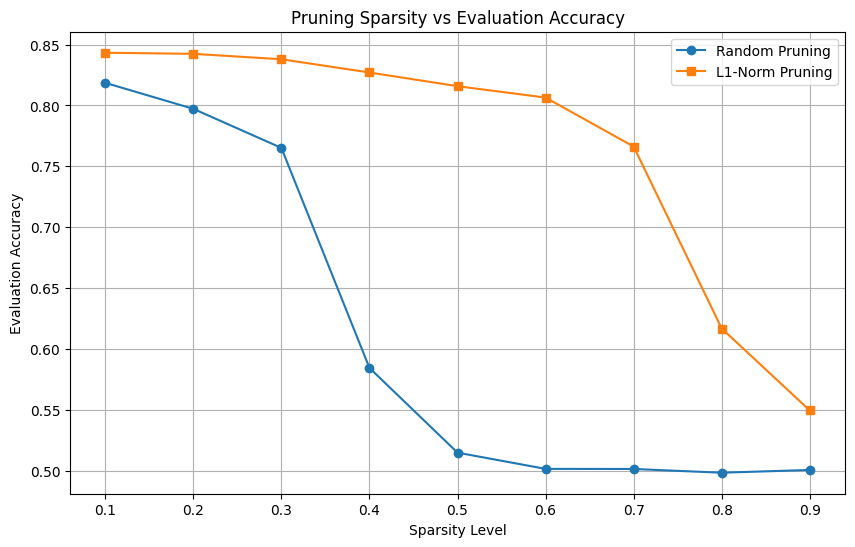

In [71]:
random_results = run_pruning(sparsity_levels, method="random", cooldown_seconds=180)
l1norm_results = run_pruning(sparsity_levels, method="l1-norm", cooldown_seconds=180)
plot_pruning_results(random_results, l1norm_results)